In [1]:
%matplotlib inline
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [28]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../../secrets/gcp_token.json"

In [29]:
client = bigquery.Client("wagon-bootcamp-428814")

In [5]:
query = client.query("""SELECT *
                        FROM chicago_crime.chicago_crime_tab
                        WHERE EXTRACT(YEAR FROM Date) > 2023
                        AND `Community Area` = '25'
                        """)

In [6]:
df_test = query.to_dataframe()
df_test['Date'] = pd.to_datetime(df_test['Date'])

In [7]:
df_ts = df_test.set_index('Date').rename(columns = {"ID": "crimes"}).resample('D').count().crimes

In [8]:
# fill gaps

full_date_range = pd.date_range(start=df_ts.index.min(), end=df_ts.index.max(), freq='D')
# Reindex the dataframe to the complete date range
service_account._DEFAULT_TOKEN_LIFETIME_SECS = df_ts.reindex(full_date_range, fill_value=0)

# Rename the index back to 'date'
df_ts.index.name = 'date'

<AxesSubplot:xlabel='date'>

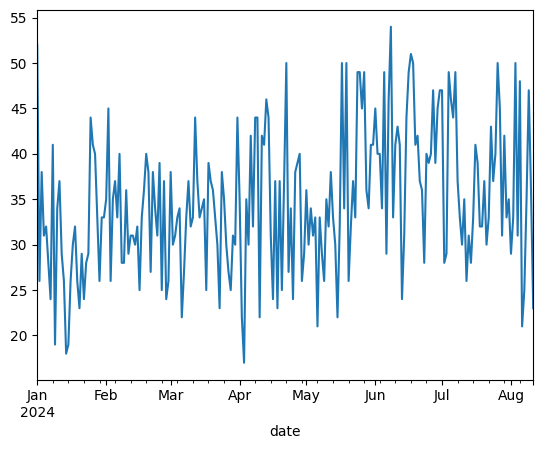

In [9]:
df_ts.plot()

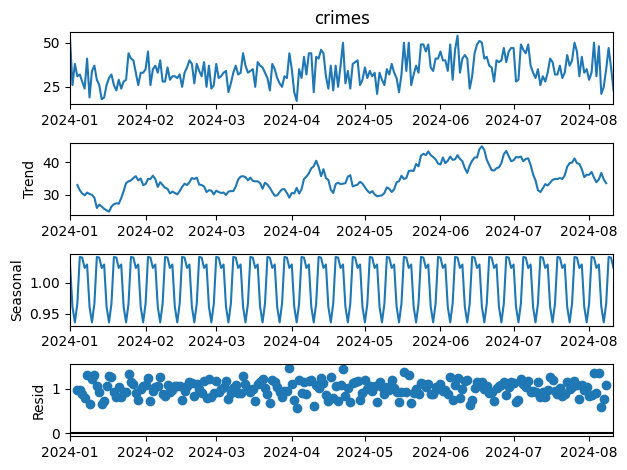

In [10]:
# now we deseasonalize
from statsmodels.tsa.seasonal import seasonal_decompose

decom_res = seasonal_decompose(df_ts, model = 'multiplicative')
seasonal = decom_res.seasonal
ts_deseasoned = df_ts/seasonal
decom_res.plot();

The time difference between the two minimums is 7 days 00:00:00


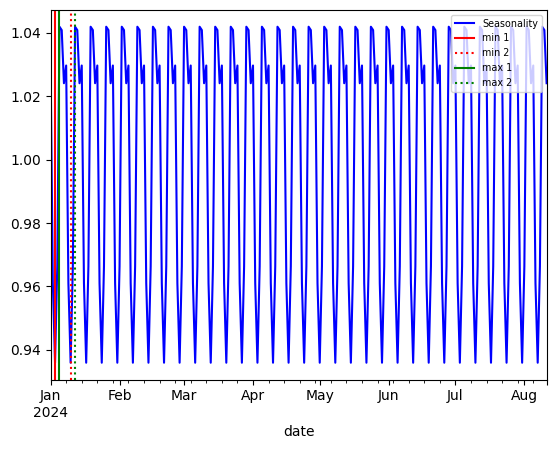

In [11]:
ax = seasonal.plot(label='Seasonality', color='blue')
min_ = seasonal.idxmin()
max_ = seasonal.idxmax()
min_2 = seasonal[max_:].idxmin()
max_2 = seasonal[min_2:].idxmax()
ax.axvline(min_,label='min 1',c='red')
ax.axvline(min_2,label='min 2',c='red', ls=':')
ax.axvline(max_,label='max 1',c='green')
ax.axvline(max_2,label='max 2',c='green', ls=':')
plt.legend(loc='upper right', fontsize='x-small')
print(f'The time difference between the two minimums is {min_2-min_}')

<AxesSubplot:xlabel='date'>

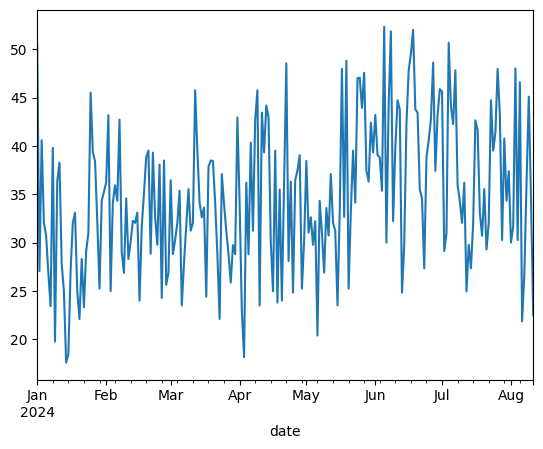

In [12]:
ts_deseasoned.plot()

In [13]:
# do differencing

ts_differenced = ts_deseasoned.diff().dropna()

In [14]:
from statsmodels.tsa.stattools import adfuller

adfuller(ts_differenced)[1]  # p-value

1.857916930096663e-15

<AxesSubplot:xlabel='date'>

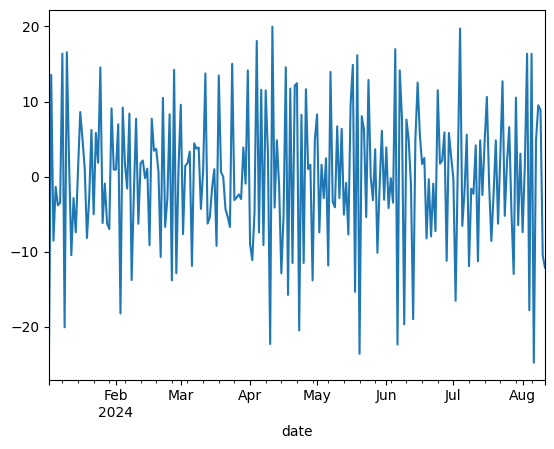

In [15]:
ts_differenced.plot()

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/home/jonahfoong/.pyenv/versions/chicago_crimes/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


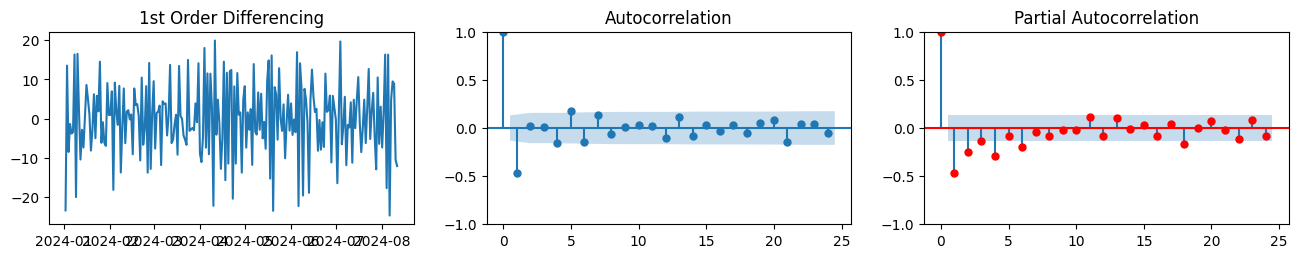

In [17]:
# ACF / PACF analysis of y_diff linearized
fig, axes = plt.subplots(1,3, figsize=(16,2.5))
axes[0].plot(ts_differenced); axes[0].set_title('1st Order Differencing')
plot_acf(ts_differenced, ax=axes[1]);
plot_pacf(ts_differenced, ax=axes[2], c='r');

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
train, test = train_test_split(df_ts, test_size = 0.2, shuffle = False)

In [20]:
import pmdarima as pm

In [21]:
model = pm.auto_arima(
    train,
    start_p=0, max_p=1,
    start_q=0, max_q=1,
    start_P=0, max_P=1,
    start_Q=0, max_Q=1,
    d=None,           # let model determine 'd'
    test='adf',       # using adf test to find optimal 'd'
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    seasonal=True,
    m = 7 # seasonal component
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=1241.471, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=1223.154, Time=0.59 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=1224.985, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1783.652, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=1232.098, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=1225.134, Time=0.49 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=1223.710, Time=0.24 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=1226.459, Time=0.16 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=1222.283, Time=0.67 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=1223.415, Time=0.26 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=1223.465, Time=0.79 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=1219.546, Time=0.83 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=1228.230, Time=0.08 sec
 ARIMA(1,0,1)(0,0,1)[7]             : AIC=1224.069, Time=0.39 sec

Best model:  ARIMA(1,0,1)(0,0,1)

In [22]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 7)   Log Likelihood                -604.773
Date:                           Tue, 27 Aug 2024   AIC                           1219.546
Time:                                   19:14:00   BIC                           1235.482
Sample:                               01-01-2024   HQIC                          1226.008
                                    - 06-27-2024                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7383      3.020      1.238      0.216      -2.180       9.656
ar.L1          0.8918      0.087     10.193      0.000       0.720       1.063
ma.L1         -0.7696      0.124     -6.190      0.000      -1.013      -0.526
ma.S.L7        0.1969      0.068      2.907      0.004       0.064       0.330
sigma2        49.9283      5.878      8.494      0.000      38.407      61.449
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 1.73
Prob(Q):                              0.71   Prob(JB):                         0.42
Heteroskedasticity (H):               1.33   Skew:                             0.17
Prob(H) (two-sided):                  0.28   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
# get error

abs(model.predict(len(test)).to_numpy() - test.to_numpy()).mean()


6.46204852551225

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [25]:
Final_model = SARIMAX(train.astype('int'),
                    order=model.order,
                    seasonal_order=model.seasonal_order,
                    enforce_invertibility=True,
                    enforce_stationarity=True)
Final_output = Final_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48131D+00    |proj g|=  2.07052D-01

At iterate    5    f=  3.40892D+00    |proj g|=  3.72818D-03

At iterate   10    f=  3.40757D+00    |proj g|=  7.89414D-03


 This problem is unconstrained.



At iterate   15    f=  3.39768D+00    |proj g|=  1.23967D-02

At iterate   20    f=  3.39690D+00    |proj g|=  1.09920D-03

At iterate   25    f=  3.39684D+00    |proj g|=  2.48446D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     29      1     0     0   2.069D-05   3.397D+00
  F =   3.3968414113408918     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


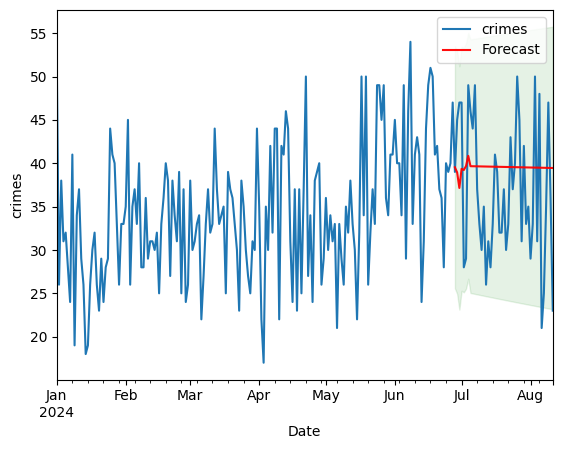

In [26]:
# Getting the forecast for 16 months
forecast = Final_output.get_forecast(steps = len(test))
forecast_conf = forecast.conf_int()
# Plot observed values
ax = df_ts.plot()
# Plot forecasted values
forecast.predicted_mean.plot(ax=ax, label='Forecast', color='red', alpha=0.95)
# Plot the range for confidence intervals
ax.fill_between(forecast_conf.index,
                forecast_conf.iloc[:, 0],
                forecast_conf.iloc[:, 1], color='g', alpha=0.1)
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('crimes')
plt.legend()
plt.show()

In [32]:
# upload to GCS
from google.cloud import storage

Final_output.save("../../local_models/dummy_model_day.pkl")

In [33]:
client = storage.Client()
bucket = client.bucket("lw_chicago_crime_pred")
blob = bucket.blob(f"lw_chicago_crime_pred/{model_filename}")
blob.upload_from_filename("../../local_models/dummy_model_day.pkl")

TypeError: unsupported type for timedelta seconds component: Series